In [2]:
%load_ext autoreload
%autoreload 2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('/tmldata1/andriush/overfit')
%matplotlib inline

np.random.seed(1)
np.set_printoptions(precision=6, suppress=True)
plot_height, legend_size = 10, 18
marker_size, line_width = 2.0, 2.0
label_size = 15


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


metrics_loss_surface/dataset=cifar10 ln=0.0 early_stopped_model=True-True models=erm_swa-erm n_eval=1024 label=seed1.npy
[test err] erm_swa=4.69%, erm=4.59%, min=4.10% (alpha=0.70) label=seed1


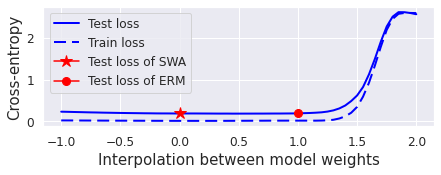

metrics_loss_surface/dataset=cifar10 ln=0.0 early_stopped_model=True-True models=sam-erm n_eval=1024 label=seed0.npy
[test err] sam=4.30%, erm=5.27%, min=4.00% (alpha=0.20) label=seed0


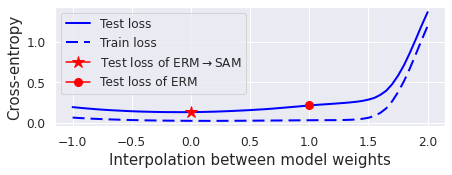

metrics_loss_surface/dataset=cifar10 ln=0.0 early_stopped_model=True-True models=sam-erm n_eval=1024 label=seed1.npy
[test err] sam=3.71%, erm=4.59%, min=3.61% (alpha=-0.15) label=seed1


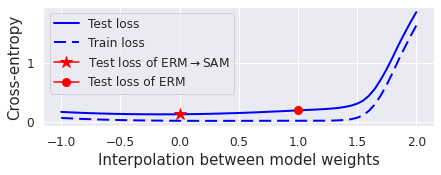

metrics_loss_surface/dataset=cifar10 ln=0.0 early_stopped_model=True-True models=sam-erm n_eval=1024 label=seed2.npy
[test err] sam=4.59%, erm=4.39%, min=4.10% (alpha=0.60) label=seed2


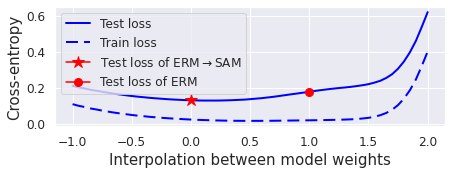

In [10]:
def map_method_names(name):
    method_names = {
        'erm_swa': 'SWA',
        'erm': 'ERM',
        'sam': 'ERM$\\rightarrow$SAM'  # 'sam': 'SAM'  # temporary hack
    }
    if name in method_names:
        return method_names[name]
    else:
        return name
    
    
plot_error = False
add_title = False
# metrics_files = glob.glob('metrics_loss_surface/*ln=0.0*n_eval=10000*noname*')
metrics_files = glob.glob('metrics_loss_surface/*ln=0.0*n_eval=1024*seed*')
# metrics_files = ['metrics_loss_surface/dataset=cifar10 ln=0.0 early_stopped_model=True-True models=sam-erm n_eval=1024 label=noname.npy',
#                  'metrics_loss_surface/dataset=cifar10 ln=0.0 early_stopped_model=True-True models=erm_swa-erm n_eval=1024 label=noname.npy']
metrics_files = sorted(metrics_files)

color1, color2 = 'blue', 'blue'
sns.set(rc={'figure.figsize':(7,2.2)}, font_scale=1.1)

for metrics_file in metrics_files:
    print(metrics_file)
    short_name = metrics_file.split('/')[-1].split('.npy')[0]
    metrics = np.load(metrics_file, allow_pickle=True).item()
    
    label_str = metrics_file.split('label=')[1].split('.')[0] if 'label=' in metrics_file else ''
    test_err_x_0 = metrics['test_errors'][metrics['alpha_range'] == 0][0]
    test_err_x_1 = metrics['test_errors'][metrics['alpha_range'] == 1][0]
    test_err_min = metrics['test_errors'].min()
    alpha_min_test_err = metrics['alpha_range'][metrics['test_errors'].argmin()]
    print('[test err] {}={:.2%}, {}={:.2%}, min={:.2%} (alpha={:.2f}) label={}'.format(
        metrics['model_name1'], test_err_x_0, metrics['model_name2'], test_err_x_1, test_err_min, alpha_min_test_err, label_str))
    
    ys1 = np.array(metrics['test_errors'] if plot_error else metrics['test_losses'])
    ys2 = np.array(metrics['train_errors'] if plot_error else metrics['train_losses'])
    ax = sns.lineplot(x=metrics['alpha_range'], y=ys1, 
                      linewidth=line_width, markersize=marker_size, label='Test loss', color=color1)
    ax = sns.lineplot(x=metrics['alpha_range'], y=ys2, 
                      linewidth=line_width, markersize=marker_size, label='Train loss', color=color2)
    ax.plot(0, ys1[metrics['alpha_range'] == 0][0], marker="*", markersize=12.0, color='red', 
            label='Test {} of {}'.format('error' if plot_error else 'loss', map_method_names(metrics['model_name1'])))
    ax.plot(1, ys1[metrics['alpha_range'] == 1][0], marker="o", markersize=8.0, color='red', 
            label='Test {} of {}'.format('error' if plot_error else 'loss', map_method_names(metrics['model_name2'])))
    dashed_linestyle = (0, (6, 3))  # 'dashed'
    ax.lines[1].set_linestyle(dashed_linestyle)
    ax.legend().get_lines()[1].set_linestyle(dashed_linestyle)
    if plot_error:
        ax.set_ylim(0.0, 0.06)
    ax.set_xlabel('Interpolation between model weights', size=label_size)
    ax.set_ylabel('Error rate' if plot_error else 'Cross-entropy', size=label_size)
    if add_title:
        plt.title('x=0: {} ($||w||_2$={:.2f}, sharpness: L={:.2f}, $\\nabla L$={:.2f}), \n x=1: {} ($||w||_2$={:.2f}, sharpness: L={:.2f}, $\\nabla L$={:.2f}))'.format(
            metrics['model_name1'], metrics['model1_norm'], metrics['model1_sharpness_obj'], metrics['model1_sharpness_grad_norm'], 
            metrics['model_name2'], metrics['model2_norm'], metrics['model2_sharpness_obj'], metrics['model2_sharpness_grad_norm']
        ))
    plt.savefig('plots/loss_surfaces {}.pdf'.format(short_name), bbox_inches='tight')
    plt.show()
